1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?
    - KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출하였다.
2. U-Net++ 모델이 성공적으로 구현되었는가?
    - U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행되었다.
3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?
    - U-Net++의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

---

task를 달성하기 위한 U-Net을 만들고 세그멘테이션 작업을 수행해보자.<br/>
먼저 KITTI 데이터셋을 준비하고 적당한 데이터 증강을 거친 후 직접 만든 U-Net 모델을 훈련, 결과물과 IoU를 계산하여 모델의 성능을 평가해보자.

In [1]:
import tensorflow as tf
import numpy as np
import os
from glob import glob
import math
from PIL import Image
import skimage
import albumentations as A
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D, concatenate, Conv2DTranspose, Dropout

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def build_augmentation(is_train=True):
  if is_train:
    return A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.RandomSizedCrop(
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    A.Resize(
                        width=224,
                        height=224
                        )
                    ])
  return A.Compose([
                A.Resize(
                    width=224,
                    height=224
                    )
                ])

라이브러리 albumentations을 이용하면 따로 augmentation 함수를 만들지 않고도 쉽게 데이터 증강을 할 수 있다.<br/>
이번 프로젝트에서는 HorizontalFlip, RandomSizedCrop, Resize 등의 메서드을 사용하였고, Compose 메서드로 통합해주었다.

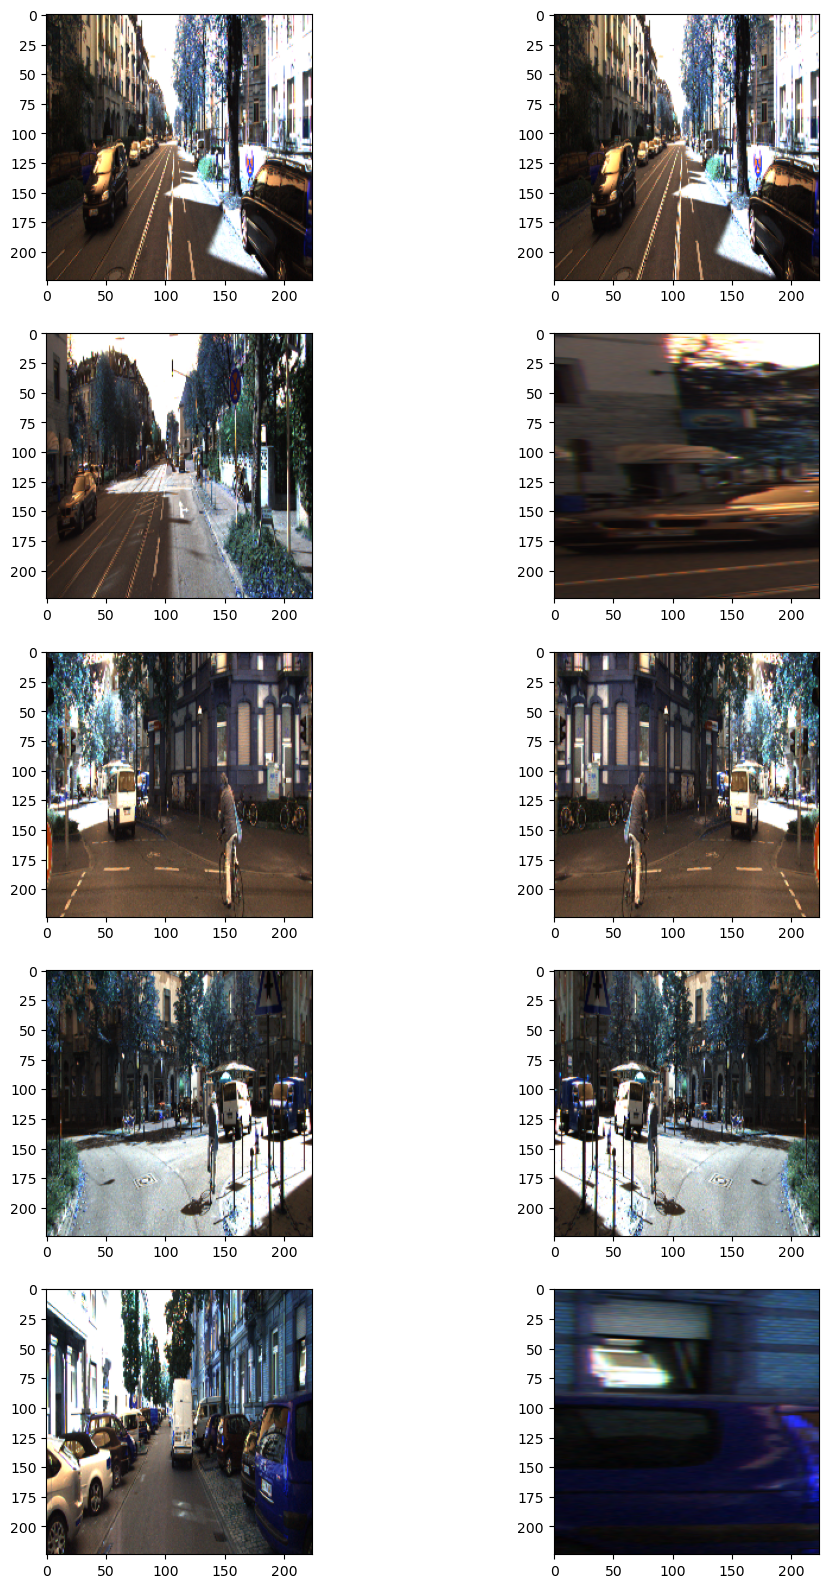

In [4]:
dir_path = os.path.join('C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Going_Deeper_CV/Segmentation/data/training')

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path + "/image" + "/*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = cv2.imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])
  
plt.show()

이미지를 보니 데이터 증강이 잘 적용되었음을 확인할 수 있다. 이제 tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터셋을 구성해보자.

In [5]:
class KittiGenerator(tf.keras.utils.Sequence):

  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):

    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size
    self.data = self.load_dataset()

  def load_dataset(self):
    input_images = glob(os.path.join(self.dir_path, "image", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):

    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = cv2.imread(input_img_path)
      _output = cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
    return inputs, outputs

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [6]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

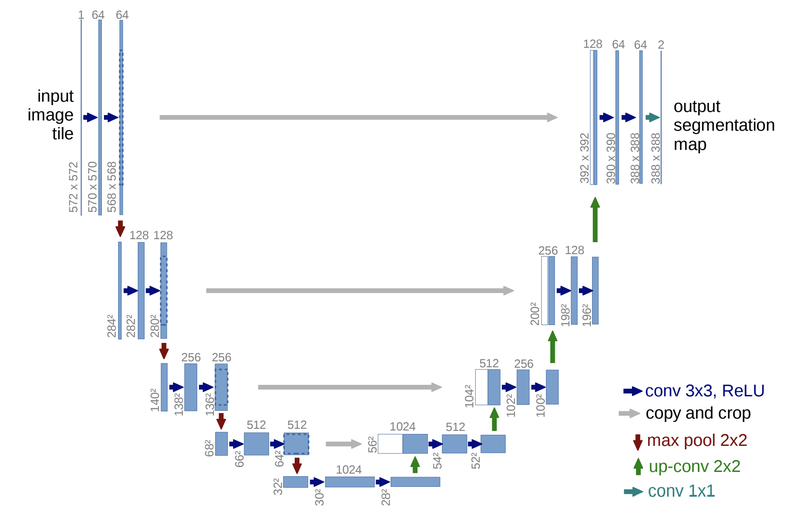

만든 generator를 이용하여 훈련 데이터셋과 테스트 데이터셋이 준비되었으니, 가장 중요한 부분인 U-Net을 만들어보자. U-Net의 아키텍처는 위의 그림과 같다.

In [7]:
def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    # Expansive path 
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    return model

아키텍쳐를 토대로 U-Net을 만들어보았다. 이제 만들어두었던 데이터셋을 가지고 모델을 훈련시켜 보자.

In [8]:
model_path = os.path.join(dir_path + '/seg_model_unet.h5')

model = build_unet()
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)

Epoch 1/100
43/43 [==============================] - 15s 146ms/step - loss: 0.4566 - val_loss: 0.3543
Epoch 2/100
43/43 [==============================] - 6s 141ms/step - loss: 0.3030 - val_loss: 0.3010
Epoch 3/100
43/43 [==============================] - 6s 145ms/step - loss: 0.2827 - val_loss: 0.2610
Epoch 4/100
43/43 [==============================] - 6s 146ms/step - loss: 0.2680 - val_loss: 0.2756
Epoch 5/100
43/43 [==============================] - 6s 144ms/step - loss: 0.3033 - val_loss: 0.2929
Epoch 6/100
43/43 [==============================] - 6s 143ms/step - loss: 0.2673 - val_loss: 0.2703
Epoch 7/100
43/43 [==============================] - 6s 143ms/step - loss: 0.2493 - val_loss: 0.2753
Epoch 8/100
43/43 [==============================] - 6s 144ms/step - loss: 0.2424 - val_loss: 0.2767
Epoch 9/100
43/43 [==============================] - 6s 142ms/step - loss: 0.2720 - val_loss: 0.2632
Epoch 10/100
43/43 [==============================] - 6s 141ms/step - loss: 0.2505 - val_l

In [17]:
def get_output(model, preproc, image_path, output_path):
     origin_img = cv2.imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

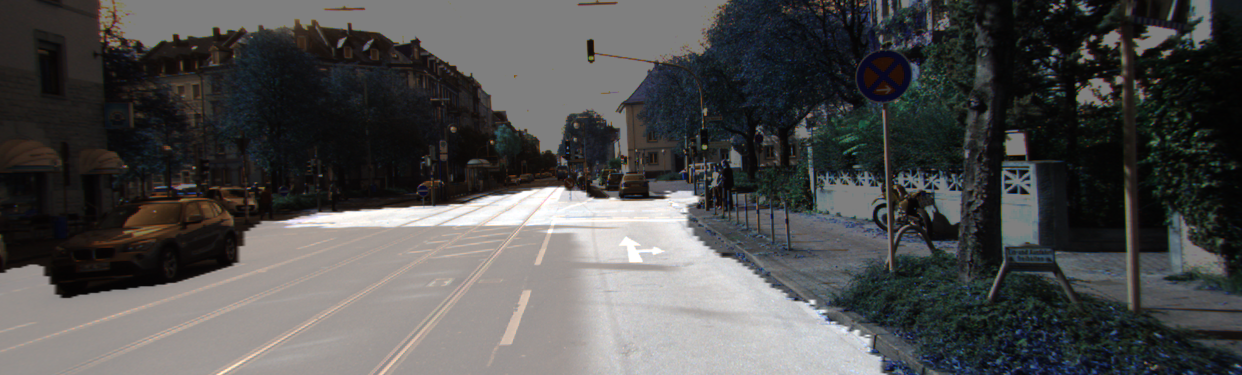

In [10]:
i = 1
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐보았다. 이렇게 시각화를 하면 학습한 모델의 결과를 눈으로 확인해 볼 수 있다.<br/>
그런데 이러한 시각화는 모델의 성능을 정량적으로 측정할 수 없다는 단점이 있다. 따라서 이를 해결하기 위해 IoU를 계산하는 방식으로 모델의 성능을 정량적으로 평가해보자.

In [18]:
def calculate_iou_score(target, prediction):
    target = np.asarray(target).flatten()
    prediction = np.asarray(prediction).flatten()
    intersection = np.sum(target * prediction)
    union = np.sum(target) + np.sum(prediction) - intersection
    iou_score = float(intersection) / float(union)
    print('IoU : %f' % iou_score)
    return iou_score


def get_output_(model, preproc, image_path, output_path, label_path):
    origin_img = cv2.imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255
    prediction = output/255 
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
     
    if label_path:   
        label_img = cv2.imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1
        return output, prediction, target
    else:
        return output, prediction, _

In [12]:
i = 1
output, prediction, target = get_output_(
     model, 
     test_preproc,
     image_path=dir_path + f'/image/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
target = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY)
calculate_iou_score(target, prediction)

IoU : 0.953550


0.9535497902749728

IoU를 계산해보니 약 0.82를 달성하였으며, U-Net이 꽤 준수한 성능을 내고 있다고 평가할 수 있다. 그런데 여기서 성능을 더 올릴 수 없을까?<br/>
실제로 U-Net은 2015년도에 세상에 등장하였으며 이는 U-Net이 나온지 벌써 8년의 시간이 지났다는 뜻이다. 8년의 시간을 지나면서 더 좋은 모델이 나오지는 않았을까? U-Net의 발전된 개량형은 없을까?<br/>
U-Net이 세상에 나온지 3년 뒤인 2018년에는 U-Net의 업그레이드 형태인 U-Net++가 등장하였으며, 2020년에 이것은 다시 한 번 업그레이드가 되면서 성능을 개선하였다.<br/>
U-Net++의 아키텍쳐는 다음과 같다.

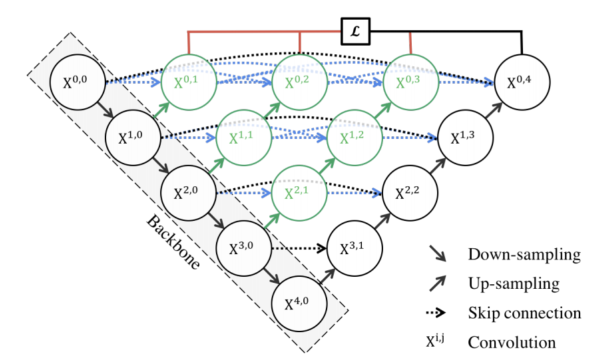

In [13]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='relu', name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(0.5, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='relu', name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5, name='dp'+stage+'_2')(x)

    return x

In [14]:
def build_unet2plus(input_shape=(224, 224, 3), num_class=1, deep_supervision=False):
    nb_filter = [64,128,256,512,1024]
    
    img_input = Input(input_shape, name='main_input')
    
    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)
    
    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)
    
    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)

    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=3)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])
    
    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)
    
    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)

    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=3)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])
    
    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)

    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=3)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])
    
    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)
    
    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)

    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])
    
    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)

    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=3)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])
    
    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)

    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=3)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])
    
    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)

    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])
    
    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)

    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])
    
    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)

    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=3)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])
    
    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)

    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=3)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])
    
    nesnet_output_1 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nesnet_output_2 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nesnet_output_3 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nesnet_output_4 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    
    if deep_supervision:
        model = tf.keras.Model(inputs=img_input, outputs=[nesnet_output_1,
                                              nesnet_output_2,
                                              nesnet_output_3,
                                              nesnet_output_4])
    else:
        model = tf.keras.Model(inputs=img_input, outputs = [nesnet_output_4])
        
    return model

In [15]:
model_path = os.path.join(dir_path + '/seg_model_unet++.h5')

model_plus = build_unet2plus()
model_plus.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy')
model_plus.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_plus.save(model_path)

Epoch 1/100
43/43 [==============================] - 24s 348ms/step - loss: 2.6274 - val_loss: 2.1197
Epoch 2/100
43/43 [==============================] - 15s 340ms/step - loss: 2.0607 - val_loss: 2.0652
Epoch 3/100
43/43 [==============================] - 15s 341ms/step - loss: 2.0040 - val_loss: 2.0236
Epoch 4/100
43/43 [==============================] - 15s 341ms/step - loss: 1.9487 - val_loss: 1.9642
Epoch 5/100
43/43 [==============================] - 15s 343ms/step - loss: 1.8085 - val_loss: 1.7866
Epoch 6/100
43/43 [==============================] - 15s 343ms/step - loss: 1.6734 - val_loss: 1.6982
Epoch 7/100
43/43 [==============================] - 15s 344ms/step - loss: 1.5699 - val_loss: 1.6676
Epoch 8/100
43/43 [==============================] - 15s 343ms/step - loss: 1.5558 - val_loss: 1.6391
Epoch 9/100
43/43 [==============================] - 15s 343ms/step - loss: 1.4986 - val_loss: 1.5826
Epoch 10/100
43/43 [==============================] - 15s 340ms/step - loss: 1.518

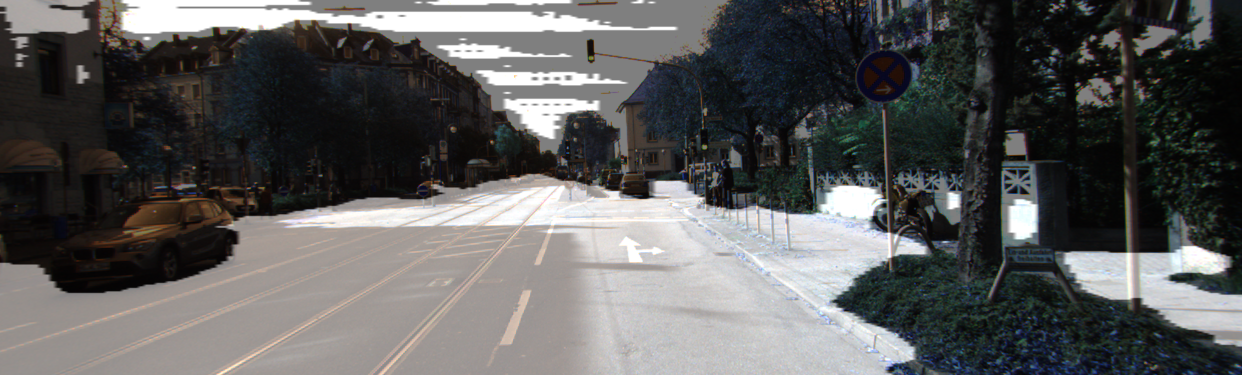

In [19]:
i = 1
get_output(
     model_plus, 
     test_preproc,
     image_path=dir_path + f'/image/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [20]:
i = 1
output, prediction, target = get_output_(
     model_plus, 
     test_preproc,
     image_path=dir_path + f'/image/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
target = cv2.cvtColor(target, cv2.COLOR_RGB2GRAY)
calculate_iou_score(target, prediction)

IoU : 0.695166


0.6951658452848994